Solved times: {'A': None, 'B': None, 'C': 156, 'D': None, 'E': None, 'F': 240, 'G': None, 'H': 237, 'I': 44, 'J': None}
Contest start: 2025-02-24 09:59:49
max_problem: I


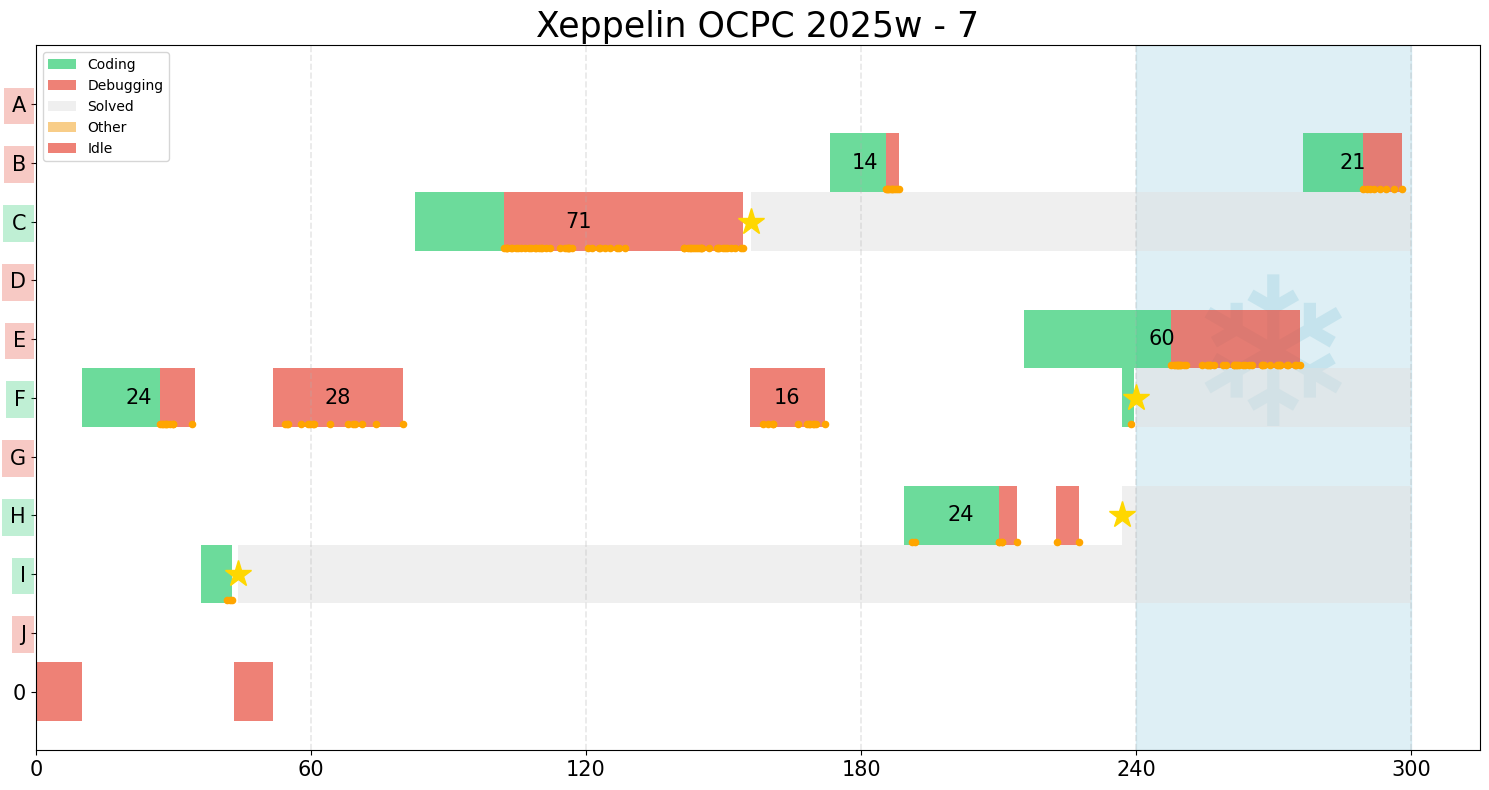

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import re

class ActivityBlock:
    def __init__(self):
        self.cpp_modifications = set()  # Set of moments when .cpp was modified
        self.binary_modifications = set()  # Set of moments when binary was modified
        self.other_modifications = set()  # Set of moments for other modifications
        
    def add_cpp_modification(self, time):
        self.cpp_modifications.add(time)
        
    def add_binary_modification(self, time):
        self.binary_modifications.add(time)
        
    def add_other_modification(self, time):
        self.other_modifications.add(time)
        
    def get_start_time(self):
        all_times = self.cpp_modifications | self.binary_modifications | self.other_modifications
        return min(all_times) if all_times else None
        
    def get_end_time(self):
        all_times = self.cpp_modifications | self.binary_modifications | self.other_modifications
        return max(all_times) if all_times else None
    
    def get_debug_start_time(self):
        if not self.binary_modifications:
            return self.get_end_time()
            
        # Convert to sorted list for processing
        mods = sorted(list(self.binary_modifications))
        start_time = self.get_start_time()
        end_time = self.get_end_time()
        duration = end_time - start_time
        
        # Split into blocks
        blocks = []
        current_block = [mods[0]]
        # two modifications are in the same block if they are close to each other (less than max_allowed_gap)
        max_allowed_gap = max(5, 0.2 * duration)
        
        for i in range(1, len(mods)):
            if mods[i] - mods[i-1] > max_allowed_gap:
                blocks.append(current_block)
                current_block = [mods[i]]
            else:
                current_block.append(mods[i])
        blocks.append(current_block)
        blocks.append([end_time])
        
        # Process blocks from start to find first valid one
        for i in range(len(blocks) - 1):
            block = blocks[i]
            block_value = (block[-1] - block[0])  # Time span of modifications
            block_value += (0.2 + 0.05 * len(block)) * duration  # Add 20% of total block length
            
            gap = blocks[i+1][0] - block[-1]
            if block_value < gap:
                continue
        
            return block[0]  # Return start of first valid block
            
        return self.get_end_time()  # No valid blocks found

    def get_displayed_debug_start_time(self):
        if not self.binary_modifications:
            return None
            
        start_time = self.get_start_time()
        end_time = self.get_end_time()
        duration = end_time - start_time
        debug_start_time = self.get_debug_start_time()
        coding_duration = debug_start_time - start_time
        debug_duration = end_time - debug_start_time

        
        # If debugging is short, consider it part of coding
        if debug_duration < 2 or debug_duration < 0.15 * duration:
            return end_time
        # If coding is short, consider it part of debugging  
        elif coding_duration < 2 or coding_duration < 0.2 * duration:
            return start_time
            
        return debug_start_time
        
    def should_display(self):
        duration = self.get_end_time() - self.get_start_time()
        return duration >= 2  # Only show blocks longer than 2 minutes

    def display_runs(self, ax, y_pos):
        for time in self.binary_modifications:
            ax.scatter(time, y_pos - 0.45, color='orange', s=20, zorder=5)
    
    def display(self, ax, y_pos, colors):
        start = self.get_start_time()
        end = self.get_end_time()
        debug_start = self.get_displayed_debug_start_time()
        
        if debug_start is None:
            # Only coding
            ax.barh(y_pos, end-start, left=start, height=1,
                   color=colors['coding'], alpha=0.7)
        else:
            # Coding + debugging
            if debug_start > start:
                ax.barh(y_pos, debug_start-start, left=start, height=1,
                       color=colors['coding'], alpha=0.7)
            ax.barh(y_pos, end-debug_start, left=debug_start, height=1,
                   color=colors['debugging'], alpha=0.7)
        
        # Add duration text if block is long enough
        if end - start >= 10:
            ax.text(start + (end-start)/2, y_pos, f'{int(end-start)}',
                   horizontalalignment='center',
                   verticalalignment='center',
                   fontsize=15)
                   
        # Display run markers
        self.display_runs(ax, y_pos)

def parse_log_line(line):
    # Parse a line like "2025-02-15 13:21:48 - ./A was modified"
    try:
        timestamp_str, action = line.strip().split(" - ")
        timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
        return timestamp, action
    except:
        return None, None

def parse_solved_info(log_lines):
    solved_times = {}
    for line in log_lines:
        # Skip empty lines or log lines
        if not line.strip() or ' - ' in line:
            continue
            
        # Try to parse "X solved hh:mm" or "X solved mm" format
        match = re.match(r'([A-Z])\s+solved\s+(\d+):?(\d+)?', line)
        if match:
            problem, hours, minutes = match.groups()
            if minutes:  # hh:mm format
                time = int(hours) * 60 + int(minutes)
            else:  # minutes only format
                time = int(minutes)
            solved_times[problem] = time
        else:
            match = re.match(r'([A-Z])\s+solved.*', line)
            if match:
                problem = match.groups()[0]
                solved_times[problem] = None
    return solved_times

def find_contest_start(log_lines):
    # Contest starts when template.cpp is modified
    for line in log_lines:
        timestamp, action = parse_log_line(line)
        if timestamp and re.search(r".*template.*modified.*", action):
            print(f"Contest start: {timestamp}")
            return timestamp
    return None

def group_activities(log_lines, contest_start):
    # First find the last problem letter
    max_problem = 'A'
    for line in log_lines:
        timestamp, action = parse_log_line(line)
        if not timestamp:
            continue
        for problem in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
            if f"./{problem}.cpp was modified" in action or f"./{problem} was modified" in action:
                max_problem = max(max_problem, problem)
    print(f"max_problem: {max_problem}")

    activities = {}
    all_activity_times = []
    
    # Process each problem separately
    for problem in range(ord('A'), ord(max_problem) + 1):
        problem = chr(problem)
        
        # Group modifications by time proximity
        current_block = None
        last_time = None
        
        for line in log_lines:
            timestamp, action = parse_log_line(line)
            if not timestamp:
                continue
                
            minutes = (timestamp - contest_start).total_seconds() / 60
            if minutes < 0 or minutes > 300:  # Skip activities outside contest time
                continue
                
            if f"./{problem}" in action and "was modified" in action:
                if last_time is None or minutes - last_time > 5:
                    if current_block and current_block.should_display():
                        key = (problem, "activity")
                        if key not in activities:
                            activities[key] = []
                        activities[key].append(current_block)
                    current_block = ActivityBlock()
                    
                if f"./{problem}.cpp was modified" in action:
                    current_block.add_cpp_modification(minutes)
                elif f"./{problem} was modified" in action:
                    current_block.add_binary_modification(minutes)
                else:
                    current_block.add_other_modification(minutes)
                    
                last_time = minutes
                all_activity_times.append(minutes)
        
        # Add final block
        if current_block and current_block.should_display():
            key = (problem, "activity")
            if key not in activities:
                activities[key] = []
            activities[key].append(current_block)
    
    # Find idle periods
    all_activity_times.sort()
    idle_periods = []
    if all_activity_times:
        current_time = 0
        for time in all_activity_times:
            if time - current_time >= 5:  # At least 5 minutes of inactivity
                idle_periods.append((current_time, time))
            current_time = time + 0.5  # Add small buffer after each activity
        
        # Check for final idle period
        if 300 - current_time >= 5:
            idle_periods.append((current_time, 300))
            
    if idle_periods:
        activities[('0', 'idle')] = idle_periods
    
    return activities

def plot_activities(activities, solved_times):
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Get all problems that appear in activities or solved_times
    existing_problems = set(k[0] for k in activities.keys()) | set(solved_times.keys())
    
    # Create full list of problems from A to the last one
    if existing_problems:
        last_problem = max(p for p in existing_problems if p != '0')
        all_problems = [chr(ord('A') + i) for i in range(ord(last_problem) - ord('A') + 1)]
        # Add idle row at the bottom
        if ('0', 'idle') in activities:
            all_problems.append('0')
    else:
        all_problems = []
    
    colors = {
        'coding': '#2ecc71', 
        'debugging': '#e74c3c', 
        'solved': '#e0e0e0',
        'other': '#f39c12',
        'idle': '#e74c3c', 
    }

    # Add frozen scoreboard background for last hour
    ax.axvspan(240, 300, color='lightblue', alpha=0.4, zorder=1)
    
    # Reverse problems list so A is at the top
    all_problems.reverse()
    
    for i, problem in enumerate(all_problems):
        if problem == '0':
            # Plot idle periods
            for start, end in activities[('0', 'idle')]:
                ax.barh(i, end-start, left=start, height=1,
                       color=colors['idle'], alpha=0.7)
                if end - start >= 10:
                    ax.text(start + (end-start)/2, i, f'{int(end-start)}',
                           horizontalalignment='center',
                           verticalalignment='center',
                           fontsize=15)
            continue
            
        # Draw solved state first (as background)
        if problem in solved_times and solved_times[problem] is not None:
            solved_time = solved_times[problem]
            ax.barh(i, 300 - solved_time, left=solved_time, 
                   height=1, color=colors['solved'], alpha=0.5)
            # Add star marker at the solved point
            ax.plot(solved_time, i, marker='*', color='gold', 
                   markersize=20, zorder=5)
        
        # Draw activity blocks
        key = (problem, "activity")
        if key in activities:
            for block in activities[key]:
                block.display(ax, i, colors)
    
    # Add snowflake symbol
    ax.text(270, len(all_problems)/2, '❄️', fontsize=150, 
            horizontalalignment='center',
            verticalalignment='center',
            color='lightblue',
            alpha=0.5, 
            zorder=-9999)
    
    ax.set_yticks(range(len(all_problems)))
    ax.set_yticklabels(all_problems)
    
    # Color problem labels based on solved status
    for i, problem in enumerate(all_problems):
        if problem == '0':  # Skip idle row
            continue
        label = ax.get_yticklabels()[i]
        if problem in solved_times and solved_times[problem] is not None:  # Problem was solved
            label.set_bbox(dict(facecolor='#2ecc71', alpha=0.3, edgecolor='none'))
        else:  # Problem was not solved
            label.set_bbox(dict(facecolor='#e74c3c', alpha=0.3, edgecolor='none'))
    
    ax.set_title('Xeppelin OCPC 2025w - 7', fontsize=25)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=colors['coding'], alpha=0.7, label='Coding'),
        Patch(facecolor=colors['debugging'], alpha=0.7, label='Debugging'),
        Patch(facecolor=colors['solved'], alpha=0.5, label='Solved'),
        Patch(facecolor=colors['other'], alpha=0.5, label='Other'),
        Patch(facecolor=colors['idle'], alpha=0.7, label='Idle'),
    ]
    ax.legend(handles=legend_elements)

    # Increase y-axis (problem names) font size
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    # Set x-axis ticks every 60 minutes
    ax.set_xticks(range(0, 301, 60))

    ax.set_ylim(-1, len(all_problems))
    
    # Make grid more visible
    ax.grid(True, axis='x', alpha=0.5, linestyle='--', linewidth=1.2)
    
    # Add grid
    ax.grid(True, axis='x', alpha=0.3)
    
    plt.tight_layout()
    return fig

def main():
    # Read the log file
    with open('ocpc-7.log', 'r') as f:
        log_lines = f.readlines()
    
    # Parse solved information from the beginning of the log
    solved_times = parse_solved_info(log_lines)
    print("Solved times:", solved_times)
    
    contest_start = find_contest_start(log_lines)
    if not contest_start:
        print("Could not find contest start!")
        return
        
    activities = group_activities(log_lines, contest_start)
    fig = plot_activities(activities, solved_times)
    plt.show()

if __name__ == "__main__":
    main()